In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
import qutip as qt


# Project-specific imports
import c2qa
import c2qa.util as util



This notebook looks at implementing the 1D Holstein model using hybrid qubit-qumode architechture (see [Sec II.3 here](https://arxiv.org/pdf/2307.06580)). 
The one-dimensional version of the Holstein model reads

$$
\hat{H} = - \sum_{\langle i, j \rangle} V f^\dagger_i f_j + \sum_i \omega b^\dagger_i b_i + \sum_i g \omega f^\dagger_i f_i (b^\dagger_i + b_i),
$$

with $V$ the hopping coefficient between the nearest neighbour pair $\langle i, j \rangle$, $\omega$ the vibration frequency, and $g$ the coupling constant. For simplicity, we will first choose a two-site Holstein model with periodic boundary conditions:
$$
\begin{aligned}
\hat{H} &= -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) \\
&\quad + \omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr) \\
&\quad + g\,\omega \Bigl[ f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) + f^\dagger_2 f_2 \left( b^\dagger_2 + b_2 \right) \Bigr].
\end{aligned}
$$
We first note that in this architechture, for e.g. the first term, we will need oscillator-mediated multi-qubit gates, however, for now, we ignore this requirement.

Using a Jordan-Wigner mapping, the first term $ -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) = -V/2(X_1X_2 + Y_1Y_2)$ corresponds to an fSim gate. We define this first below.
The $\omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr)$ term can be implemented at each site individually using a phase space rotation gate $\text{exp}(-i\theta n_i)$, with $\theta = \omega$. Finally, the boson-fermion coupling term $f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) = (Z_1 + 1)(b_1^{\dagger} + b_1)$, which is easy to implement as all terms in the sum commute and each
has a simple implementation; the term proportional to $Z_1$ generates a conditional displacement gate and the remaining term is a dispacement.


In [2]:
def hopping_term(theta):
    """
    Create an fSim gate defined as U(t)=exp(i Vt/2 (XX+YY)).
    """
    
    U = np.array([
        [1,               0,               0, 0],
        [0,  np.cos(theta), 1j * np.sin(theta), 0],
        [0, 1j * np.sin(theta),  np.cos(theta), 0],
        [0,               0,               0, 1]
    ])
    return UnitaryGate(U, label="fSim")


Below, we create the (noiseless) circuit for Trotterization between two sites, which returns a statevector. We also create a function to compute the fermion & boson occupations of this statevector. A quick note about displacements: bosonic qiskit defines $D(\alpha) = \text{exp}(\alpha a^\dagger- \alpha^* a)$. So, to implement $ \text{exp}(-i\phi(a^\dagger + a))$, we need to choose $D(-i\phi)$. The same is true for conditional displacements.


In [3]:

def simulate_holstein_model(dt, num_trotter, v, omega, g,
                              fermion_init, 
                              num_qubits_per_qumode):
    """
    Simulate the two-site Holstein model using a Trotter decomposition.
    
    """
    num_sites = 2
    # Create registers
    qmr = c2qa.QumodeRegister(num_qumodes=num_sites,
                              num_qubits_per_qumode=num_qubits_per_qumode)
    qbr = qiskit.QuantumRegister(num_sites)
    circuit = c2qa.CVCircuit(qmr, qbr)
    
    # initialize qubits
    fermion_state = list(fermion_init)
    if len(fermion_state) != 2**num_sites:
        raise ValueError("Fermionic state vector must have length 2**(num_sites) = 4")
    
    circuit.initialize(fermion_state, qbr)
    
    for step in range(num_trotter):
        fsim_gate = hopping_term(v * dt) 
        circuit.append(fsim_gate, [qbr[0], qbr[1]]) #hopping term
        
        # Bosonic rotation term
        circuit.cv_r(-omega * dt, qmr[0])
        circuit.cv_r(-omega * dt, qmr[1])
        
        # Coupling term
        circuit.cv_c_d(-1j * (g * omega / 2) * dt, qmr[0], qbr[0])
        circuit.cv_d(-1j * (g * omega / 2) * dt, qmr[0])
        circuit.cv_c_d(-1j * (g * omega / 2) * dt, qmr[1], qbr[1])
        circuit.cv_d(-1j * (g * omega / 2) * dt, qmr[1])
    
    state, _, _ = c2qa.util.simulate(circuit)
    
    # Convert to Qobj for easier comparisons
    dims = [[2, 2, 2**num_qubits_per_qumode, 2**num_qubits_per_qumode],
            [1, 1, 1, 1]]
    state_qobj = qt.Qobj(state, dims=dims)
    d_b = 2**num_qubits_per_qumode
    S_bos = 0
    for i in range(d_b):
        for j in range(d_b):
            ket = qt.tensor(qt.basis(d_b, j), qt.basis(d_b, i))
            bra = qt.tensor(qt.basis(d_b, i), qt.basis(d_b, j)).dag()
            S_bos += ket * bra
    I_ferm = qt.tensor(qt.qeye(2), qt.qeye(2)) 
    P = qt.tensor(I_ferm, S_bos)
    state_qobj = P * state_qobj
    return state_qobj, circuit

So for $N=2$, the Trotter step requires a total of 7 gates: 1 two-qubit gate for the hopping term, 2 mode rotations (one per site), 2 displacements, and 2 conditional displacements. For a 1D system with $N>2$ sites under periodic boundary conditions, the hopping term is implemented with $N$ two-qubit gates (one for each unique nearest-neighbor pair), while the on-site terms scale as $N$ mode rotations, $N$ displacements, and $N$ conditional displacements. Thus, the overall gate count per Trotter step scales as $N$ two-qubit gates plus $N$ mode rotations plus $N$ displacements plus $N$ conditional displacements (a total of $4N$ gates). We'll also just need $N$ qubits and $N$ modes. **NOTE this is without considering the use of oscillator mediated gates.**

We can then compare this to the "exact" dynamics by using qutips master equation solver `mesolve`. 

In [4]:
def exact_qutip_holstein_sim(v=1.0, omega=1.0, g=1.0, N_b=8,
                             t_max=5, num_steps=100,
                             fermion_init= [1, 0 , 0 ,0]):
    """
    Perform an exact simulation of the two-site Holstein model using qutip’s mesolve.
    """
    times_exact = np.linspace(0, t_max, num_steps)
    
    # fermion initialization
    fermion_state = np.array(fermion_init, dtype=complex)
    if fermion_state.size != 4:
        raise ValueError("Fermionic state vector must have 4 elements")
    psi_f = qt.Qobj(fermion_state, dims=[[2, 2], [1, 1]])
    
    # boson initialization
    psi_b1 = qt.basis(N_b, 0)
    psi_b2 = qt.basis(N_b, 0)
    
    psi0_exact = qt.tensor(psi_f, psi_b2, psi_b1) # to match qiskit order
    
    # build Hamiltonian 
    I_2 = qt.qeye(2)
    f1 = qt.tensor(qt.destroy(2), I_2)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2))
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    
    I_b = qt.qeye(N_b)
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    
    f1_tot = qt.tensor(f1, I_b, I_b)
    f2_tot = qt.tensor(f2, I_b, I_b)
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    I_f_full = qt.tensor(qt.qeye(2), qt.qeye(2))
    b1_tot = qt.tensor(I_f_full, b1, I_b)
    b1_dag_tot = b1_tot.dag()
    b2_tot = qt.tensor(I_f_full, I_b, b2)
    b2_dag_tot = b2_tot.dag()
    
    H_hop = -v * (f1_tot.dag() * f2_tot + f2_tot.dag() * f1_tot)
    H_phonon = omega * (b1_dag_tot * b1_tot + b2_dag_tot * b2_tot)
    H_int = g * omega * (n1_tot * (b1_tot + b1_dag_tot) +
                          n2_tot * (b2_tot + b2_dag_tot))
    H_exact = H_hop + H_phonon + H_int
    
    result_exact = qt.mesolve(H_exact, psi0_exact, times_exact, [], [])
    return result_exact

# Dynamics
### Populations
We can now compare the dynamics by visualising the Boson and Fermion occupations over time for various Hamiltonian parameters.

In [5]:
def compute_expectations_qutip(states, N_b=8):
    """
    Computes the fermion populations and boson occupations on both sites from a qutip state
    """
    I_2 = qt.qeye(2)
    #operators on the two-qubit fermionic space.
    f1 = qt.tensor(qt.destroy(2), I_2)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2))
    
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    
    I_f_full = qt.tensor(qt.qeye(2), qt.qeye(2))
    I_b = qt.qeye(N_b)
    
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    pop_site1 = qt.expect(n1_tot, states)
    pop_site2 = qt.expect(n2_tot, states)
    
    # Bosonic operators
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    b1_tot = qt.tensor(I_f_full, b1, I_b)
    b2_tot = qt.tensor(I_f_full, I_b, b2)
    
    occ_op_b1 = b1_tot.dag() * b1_tot
    occ_op_b2 = b2_tot.dag() * b2_tot
    occ_b1 = qt.expect(occ_op_b1, states)
    occ_b2 = qt.expect(occ_op_b2, states)
    
    return pop_site1, pop_site2, occ_b1, occ_b2

In [6]:
def run_holstein_population_simulation(dt_qutip, dt_trotter, t_max, v, omega, g, num_qubits_per_qumode, N_b, fermion_init):
    """
    Runs the Holstein model simulation using both the exact qutip method and Trotter simulation,
    returning the fermion & boson occupations at each site for both methods.
    """

    # Qutip parameters for the exact simulation
    num_steps_qutip = int(t_max / dt_qutip) + 1
    times_qutip = np.linspace(0, t_max, num_steps_qutip)

    # EXACT simulation using qutip
    exact_result = exact_qutip_holstein_sim(v=v, omega=omega, g=g, N_b=N_b,
                                             t_max=t_max, num_steps=num_steps_qutip, fermion_init=fermion_init)
    fermion_pop1_exact, fermion_pop2_exact, boson_occ1_exact, boson_occ2_exact = compute_expectations_qutip(exact_result.states, N_b=N_b)

    # Trotter simulation
    trotter_states = []
    num_steps_trotter = int(t_max / dt_trotter) + 1
    times_trotter = np.linspace(0, t_max, num_steps_trotter)

    for step, current_time in enumerate(times_trotter):
        state_trotter, _ = simulate_holstein_model(dt=dt_trotter, num_trotter=step,
                                              v=v, omega=omega, g=g,
                                              fermion_init=fermion_init,
                                              num_qubits_per_qumode=num_qubits_per_qumode)
        # Append the current qobj state to list
        trotter_states.append(state_trotter)

    # Compute expectations from the list of trotter states
    trotter_fermion_pop1, trotter_fermion_pop2, trotter_boson_occ1, trotter_boson_occ2 = compute_expectations_qutip(trotter_states, N_b=N_b)

    return {
        "times_exact": times_qutip,
        "fermion_pop1_exact": fermion_pop1_exact,
        "fermion_pop2_exact": fermion_pop2_exact,
        "boson_occ1_exact": boson_occ1_exact,
        "boson_occ2_exact": boson_occ2_exact,
        "times_trotter": times_trotter,
        "trotter_fermion_pop1": trotter_fermion_pop1,
        "trotter_fermion_pop2": trotter_fermion_pop2,
        "trotter_boson_occ1": trotter_boson_occ1,
        "trotter_boson_occ2": trotter_boson_occ2,
    }


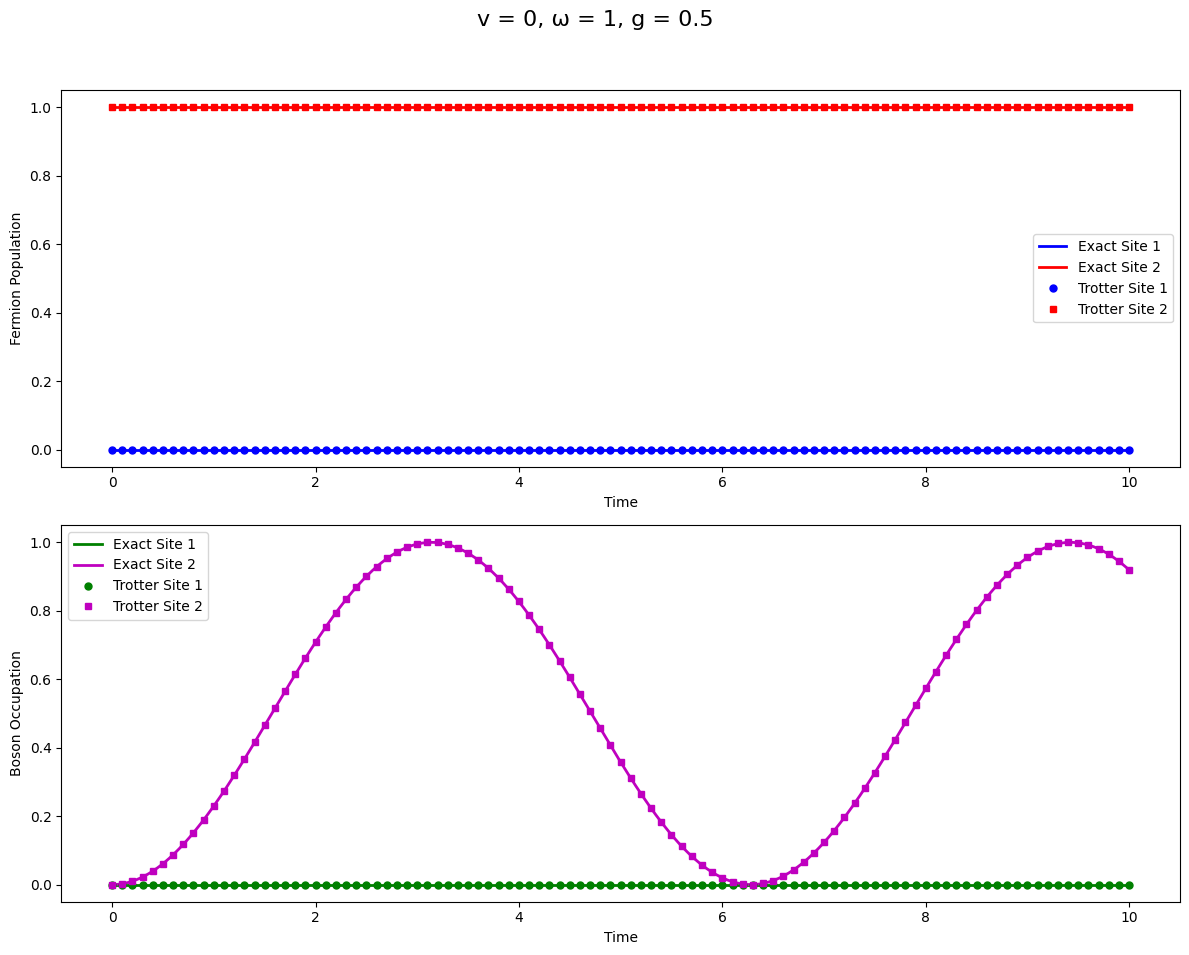

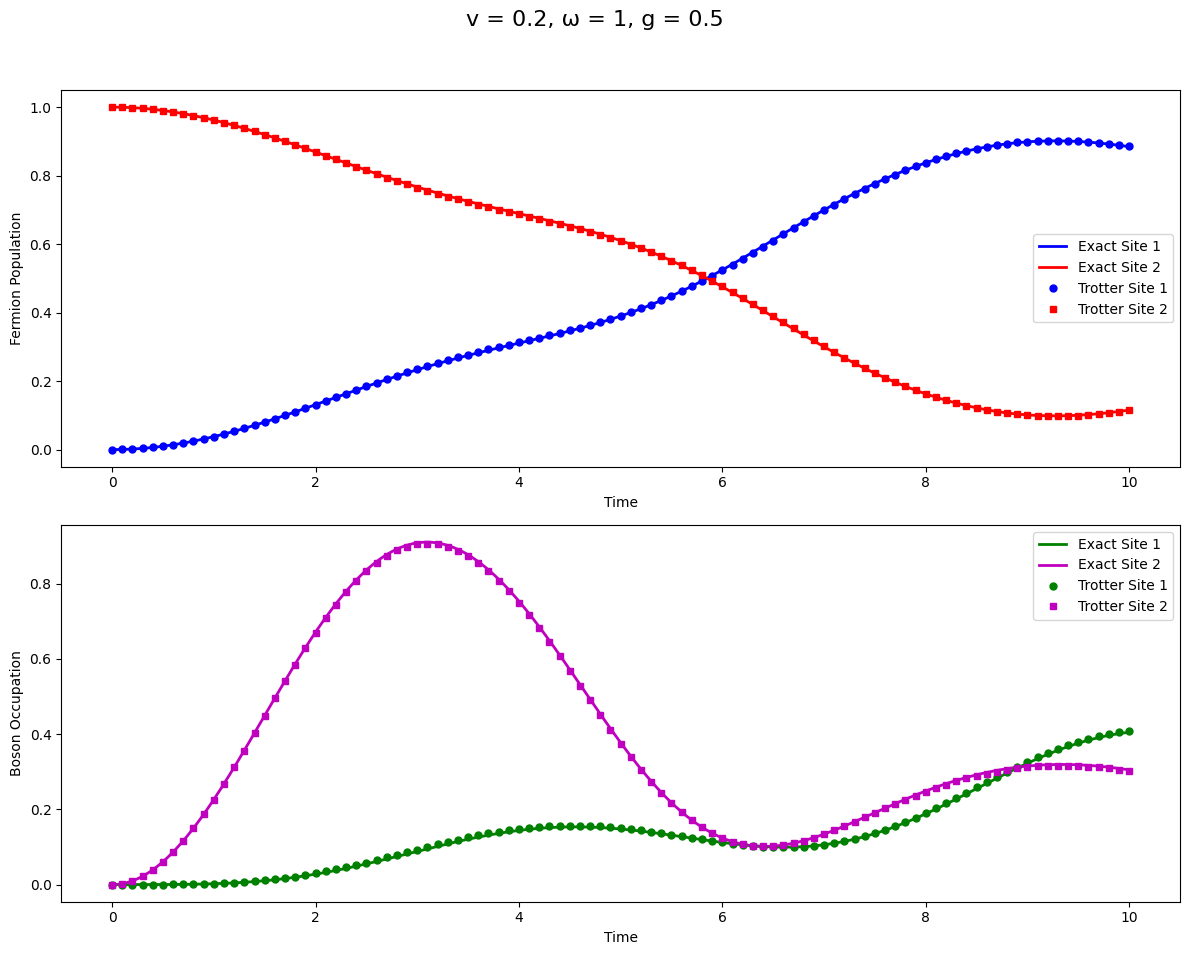

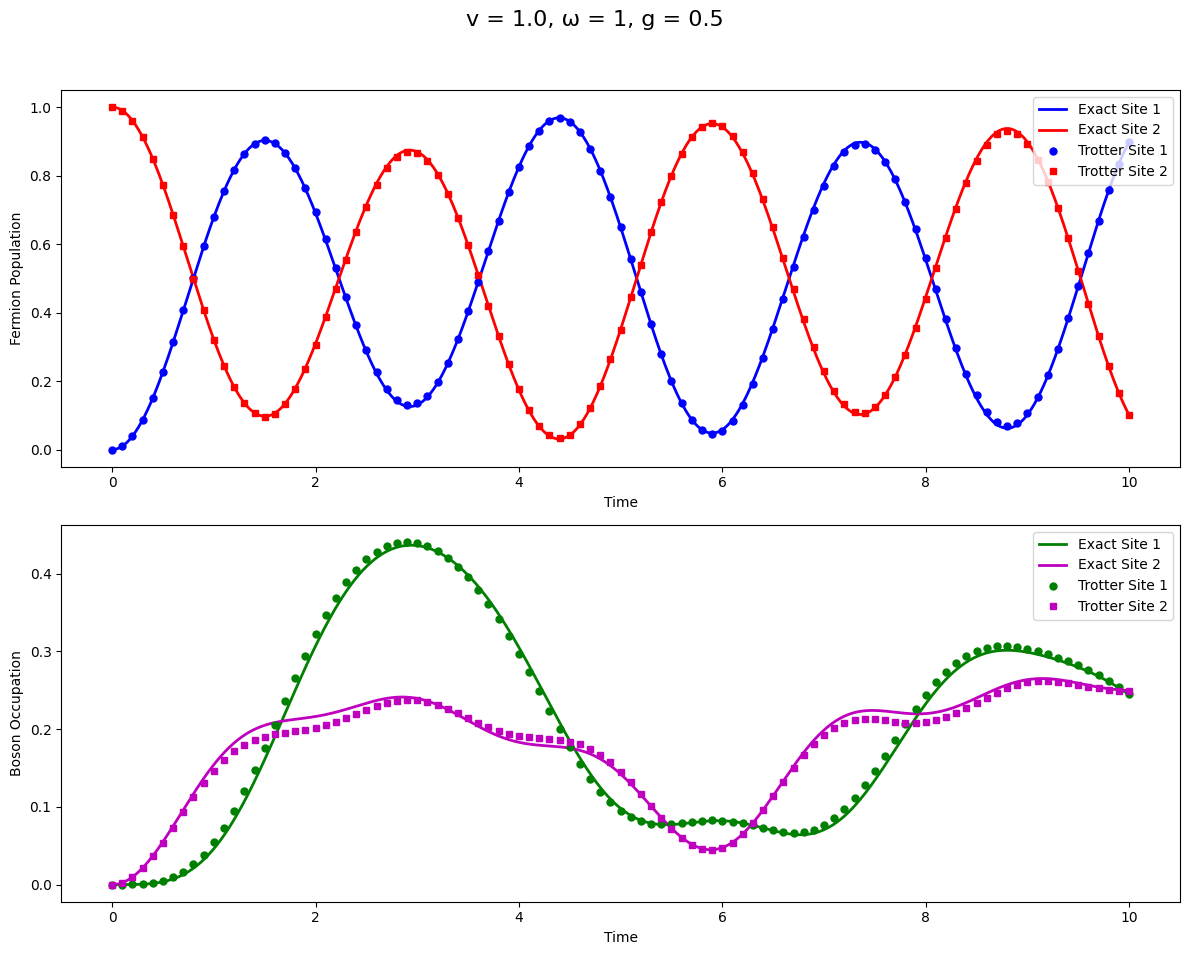

In [ ]:
dt_trotter = 0.1          # Trotter time step
dt_qutip = 0.01          # qutip timestep
t_max = 10.0             # Final time
num_qubits_per_qumode = 3   # qubits per mode for trotterization
N_b = 2**num_qubits_per_qumode  # cutoff for exact simulation
fermion_init = [0, 1, 0, 0]   # initial state of the fermions

# Base parameters
base_v = 1.0
base_omega = 1.0
base_g = 0.5

# Varying v (with omega and g fixed)
param_sets_v = [
    {"label": "v = 0, ω = 1, g = 0.5", "v": 0.0, "omega": base_omega, "g": base_g},
    {"label": "v = 0.2, ω = 1, g = 0.5", "v": 0.2, "omega": base_omega, "g": base_g},
    {"label": "v = 1.0, ω = 1, g = 0.5", "v": base_v, "omega": base_omega, "g": base_g},
]

for params in param_sets_v:
    label, v, omega, g = params["label"], params["v"], params["omega"], params["g"]
    
    # Run the simulation (replace with your simulation function)
    sim_data = run_holstein_population_simulation(dt_qutip, dt_trotter, t_max, v, omega, g, 
                                                   num_qubits_per_qumode, N_b, fermion_init)
    
    # Extract simulation data
    times_exact = sim_data["times_exact"]
    times_trotter = sim_data["times_trotter"]
    fermion_pop1_exact = sim_data["fermion_pop1_exact"]
    fermion_pop2_exact = sim_data["fermion_pop2_exact"]
    boson_occ1_exact = sim_data["boson_occ1_exact"]
    boson_occ2_exact = sim_data["boson_occ2_exact"]
    trotter_fermion_pop1 = sim_data["trotter_fermion_pop1"]
    trotter_fermion_pop2 = sim_data["trotter_fermion_pop2"]
    trotter_boson_occ1 = sim_data["trotter_boson_occ1"]
    trotter_boson_occ2 = sim_data["trotter_boson_occ2"]
    
    # Create plots to compare exact vs. trotter simulation results
    plt.figure(figsize=(12, 10))
    plt.suptitle(label, fontsize=16)
    
    # Plot fermion occupations
    plt.subplot(2, 1, 1)
    plt.plot(times_exact, fermion_pop1_exact, 'b-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, fermion_pop2_exact, 'r-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_fermion_pop1, 'bo', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_fermion_pop2, 'rs', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Fermion Population")
    plt.legend()
    
    # Plot boson occupations
    plt.subplot(2, 1, 2)
    plt.plot(times_exact, boson_occ1_exact, 'g-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, boson_occ2_exact, 'm-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_boson_occ1, 'go', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_boson_occ2, 'ms', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Boson Occupation")
    plt.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


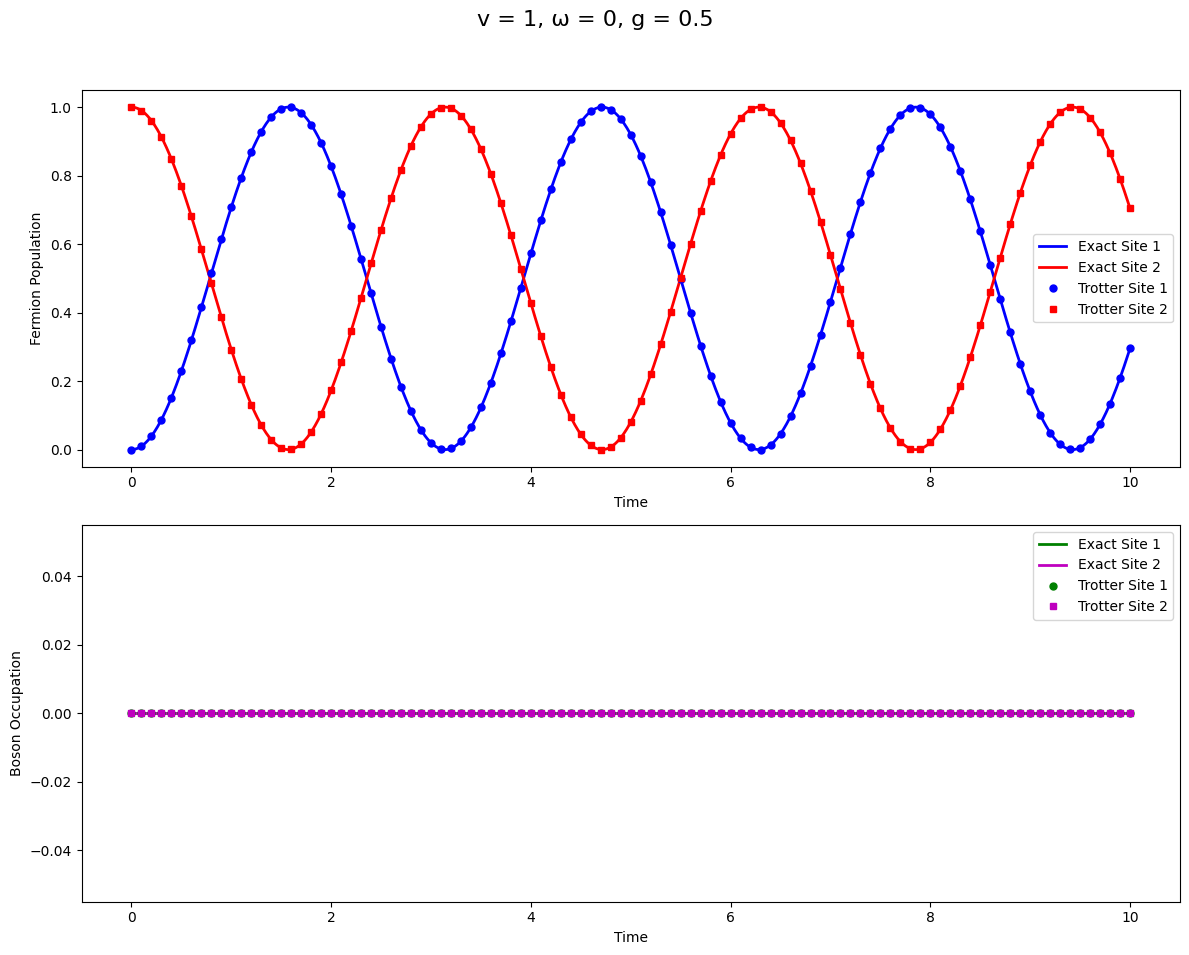

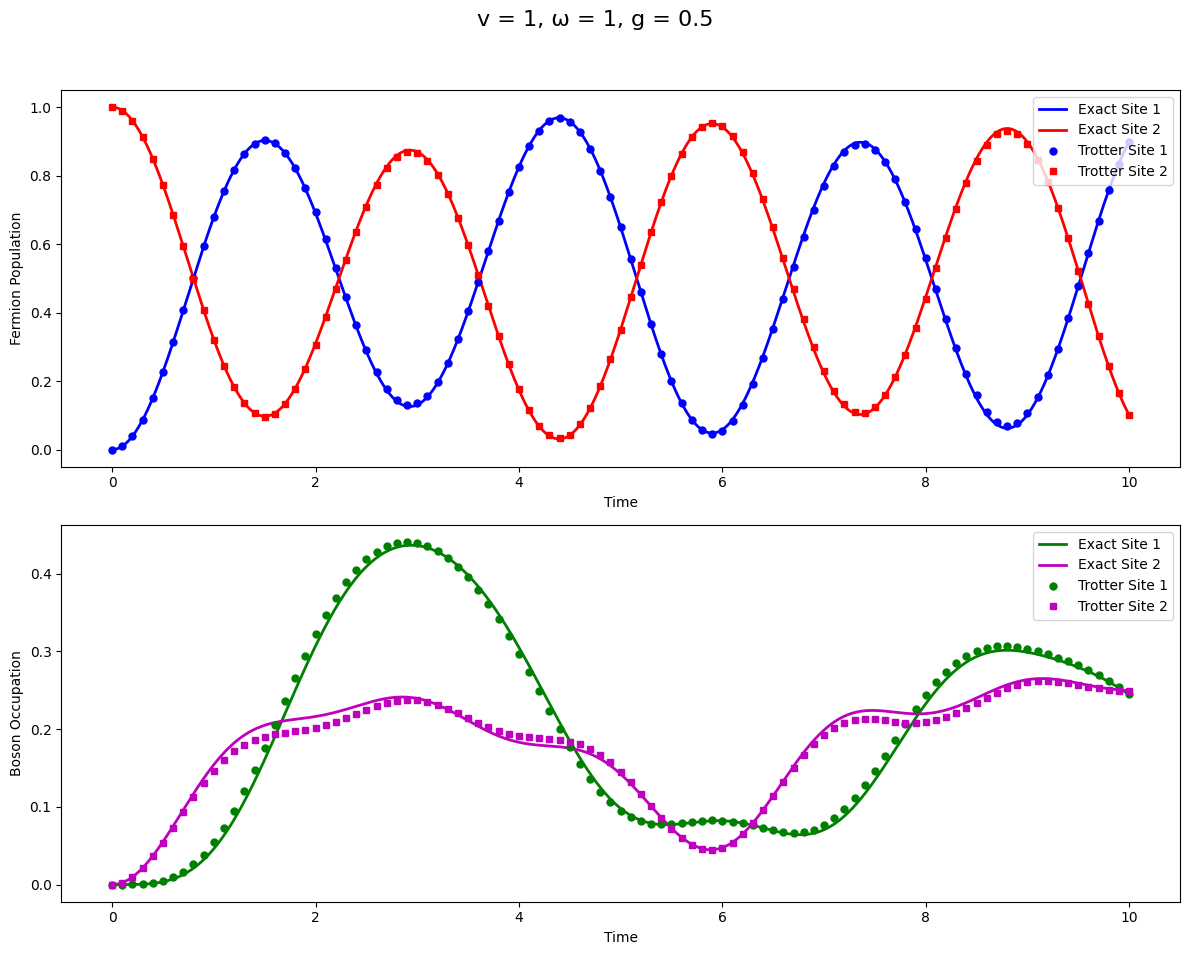

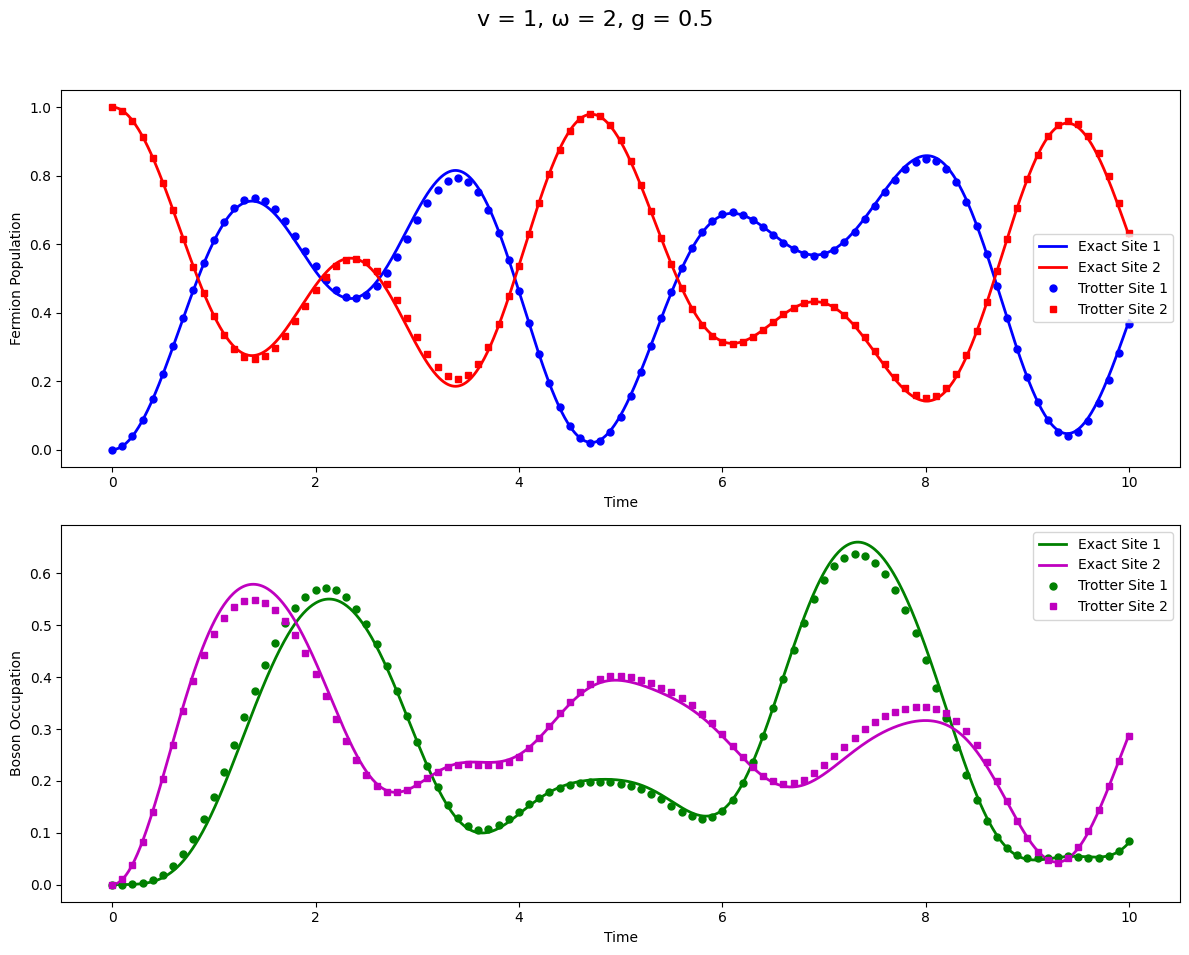

In [14]:
# Varying omega (with v and g fixed)
param_sets_omega = [
    {"label": "v = 1, ω = 0, g = 0.5", "v": base_v, "omega": 0.0, "g": base_g},
    {"label": "v = 1, ω = 1, g = 0.5", "v": base_v, "omega": base_omega, "g": base_g},
    {"label": "v = 1, ω = 2, g = 0.5", "v": base_v, "omega": 2.0, "g": base_g},
]

for params in param_sets_omega:
    label, v, omega, g = params["label"], params["v"], params["omega"], params["g"]
    
    sim_data = run_holstein_population_simulation(dt_qutip, dt_trotter, t_max, v, omega, g, 
                                                   num_qubits_per_qumode, N_b, fermion_init)
    
    times_exact = sim_data["times_exact"]
    times_trotter = sim_data["times_trotter"]
    fermion_pop1_exact = sim_data["fermion_pop1_exact"]
    fermion_pop2_exact = sim_data["fermion_pop2_exact"]
    boson_occ1_exact = sim_data["boson_occ1_exact"]
    boson_occ2_exact = sim_data["boson_occ2_exact"]
    trotter_fermion_pop1 = sim_data["trotter_fermion_pop1"]
    trotter_fermion_pop2 = sim_data["trotter_fermion_pop2"]
    trotter_boson_occ1 = sim_data["trotter_boson_occ1"]
    trotter_boson_occ2 = sim_data["trotter_boson_occ2"]
    
    plt.figure(figsize=(12, 10))
    plt.suptitle(label, fontsize=16)
    
    plt.subplot(2, 1, 1)
    plt.plot(times_exact, fermion_pop1_exact, 'b-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, fermion_pop2_exact, 'r-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_fermion_pop1, 'bo', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_fermion_pop2, 'rs', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Fermion Population")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(times_exact, boson_occ1_exact, 'g-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, boson_occ2_exact, 'm-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_boson_occ1, 'go', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_boson_occ2, 'ms', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Boson Occupation")
    plt.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

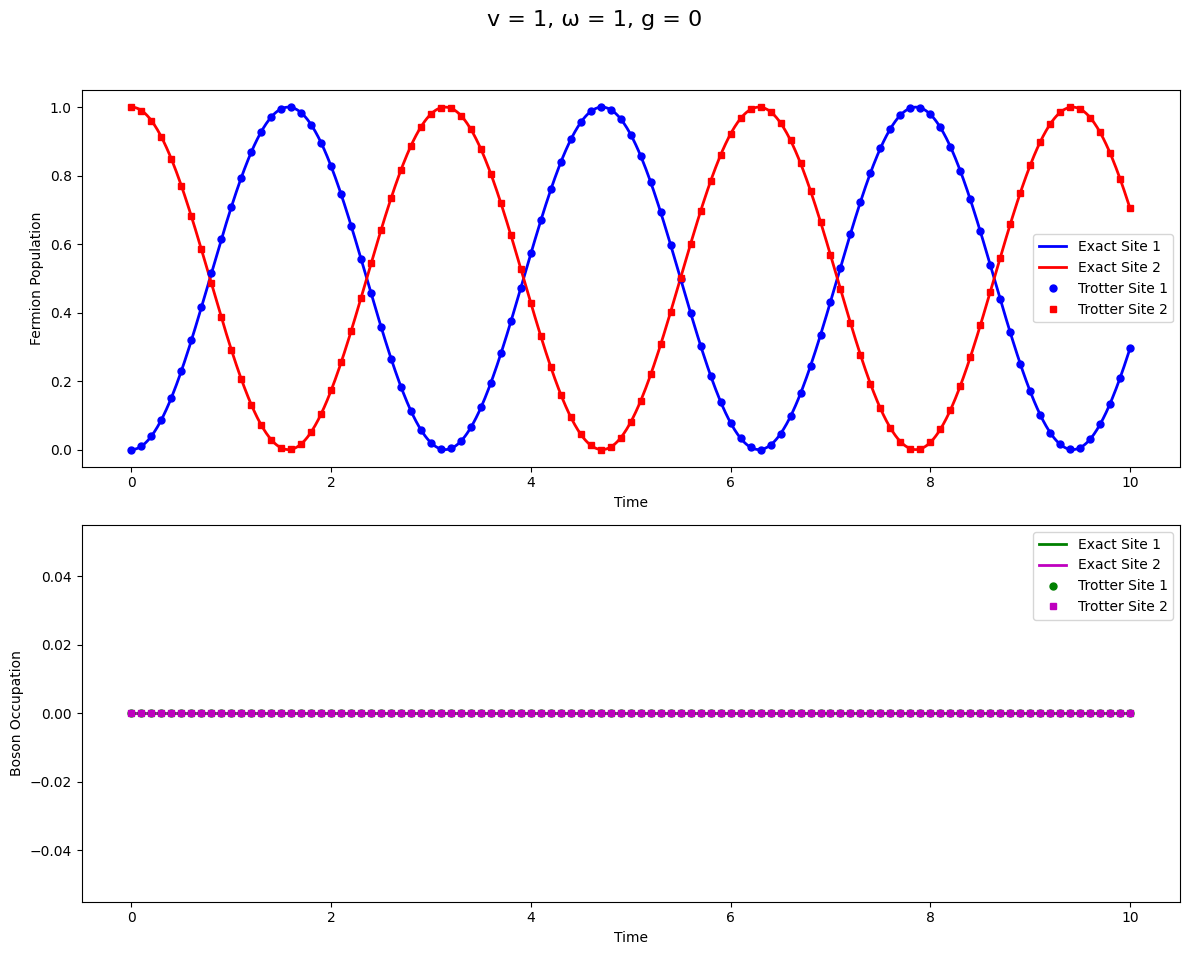

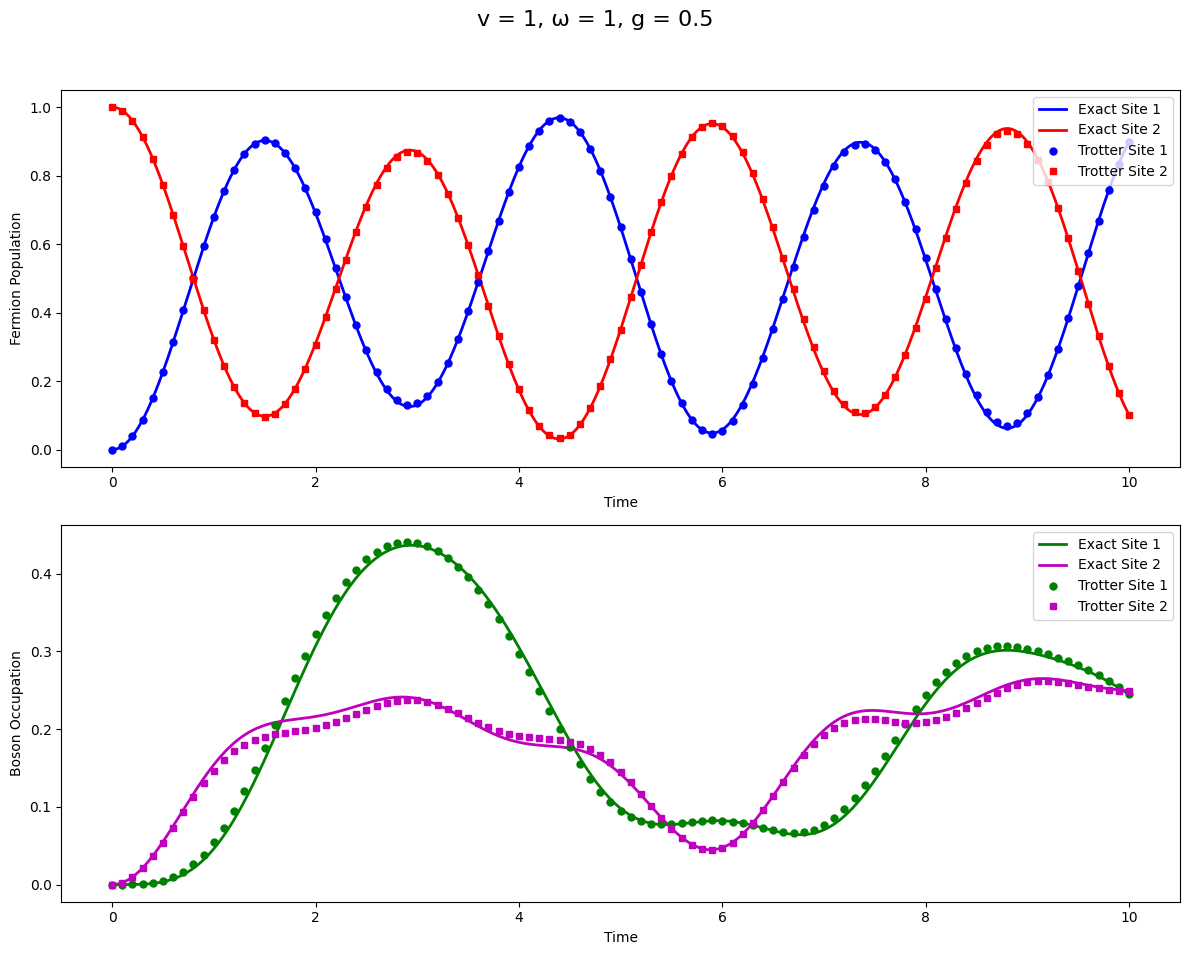

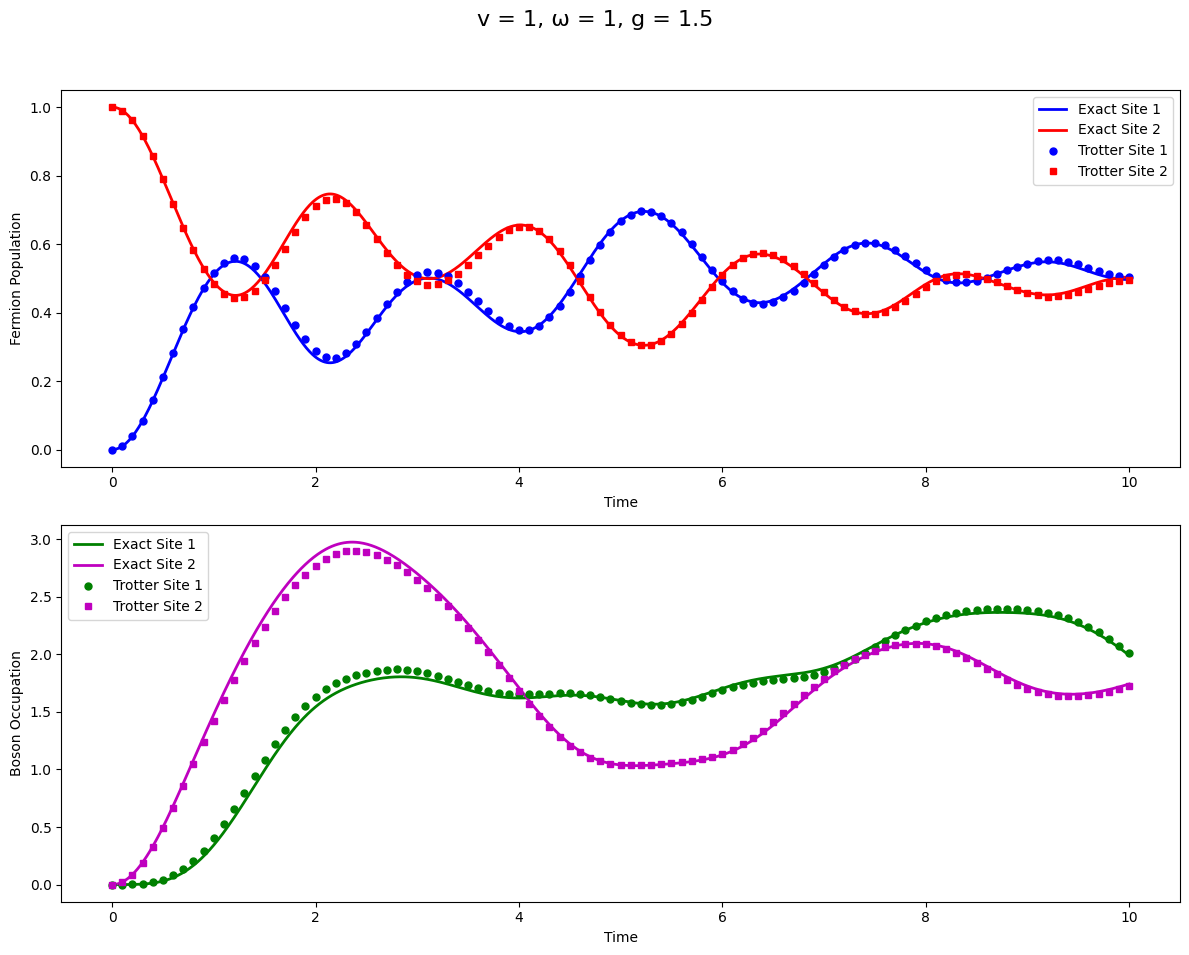

In [16]:
# Varying g (with v and omega fixed)
param_sets_g = [
    {"label": "v = 1, ω = 1, g = 0", "v": base_v, "omega": base_omega, "g": 0.0},
    {"label": "v = 1, ω = 1, g = 0.5", "v": base_v, "omega": base_omega, "g": base_g},
    {"label": "v = 1, ω = 1, g = 1.5", "v": base_v, "omega": base_omega, "g": 1.5},
]

for params in param_sets_g:
    label, v, omega, g = params["label"], params["v"], params["omega"], params["g"]
    
    sim_data = run_holstein_population_simulation(dt_qutip, dt_trotter, t_max, v, omega, g, 
                                                   num_qubits_per_qumode, N_b, fermion_init)
    
    times_exact = sim_data["times_exact"]
    times_trotter = sim_data["times_trotter"]
    fermion_pop1_exact = sim_data["fermion_pop1_exact"]
    fermion_pop2_exact = sim_data["fermion_pop2_exact"]
    boson_occ1_exact = sim_data["boson_occ1_exact"]
    boson_occ2_exact = sim_data["boson_occ2_exact"]
    trotter_fermion_pop1 = sim_data["trotter_fermion_pop1"]
    trotter_fermion_pop2 = sim_data["trotter_fermion_pop2"]
    trotter_boson_occ1 = sim_data["trotter_boson_occ1"]
    trotter_boson_occ2 = sim_data["trotter_boson_occ2"]
    
    plt.figure(figsize=(12, 10))
    plt.suptitle(label, fontsize=16)
    
    plt.subplot(2, 1, 1)
    plt.plot(times_exact, fermion_pop1_exact, 'b-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, fermion_pop2_exact, 'r-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_fermion_pop1, 'bo', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_fermion_pop2, 'rs', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Fermion Population")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(times_exact, boson_occ1_exact, 'g-', label="Exact Site 1", linewidth=2)
    plt.plot(times_exact, boson_occ2_exact, 'm-', label="Exact Site 2", linewidth=2)
    plt.plot(times_trotter, trotter_boson_occ1, 'go', label="Trotter Site 1", markersize=5)
    plt.plot(times_trotter, trotter_boson_occ2, 'ms', label="Trotter Site 2", markersize=5)
    plt.xlabel("Time")
    plt.ylabel("Boson Occupation")
    plt.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


### Number of Trotter Steps


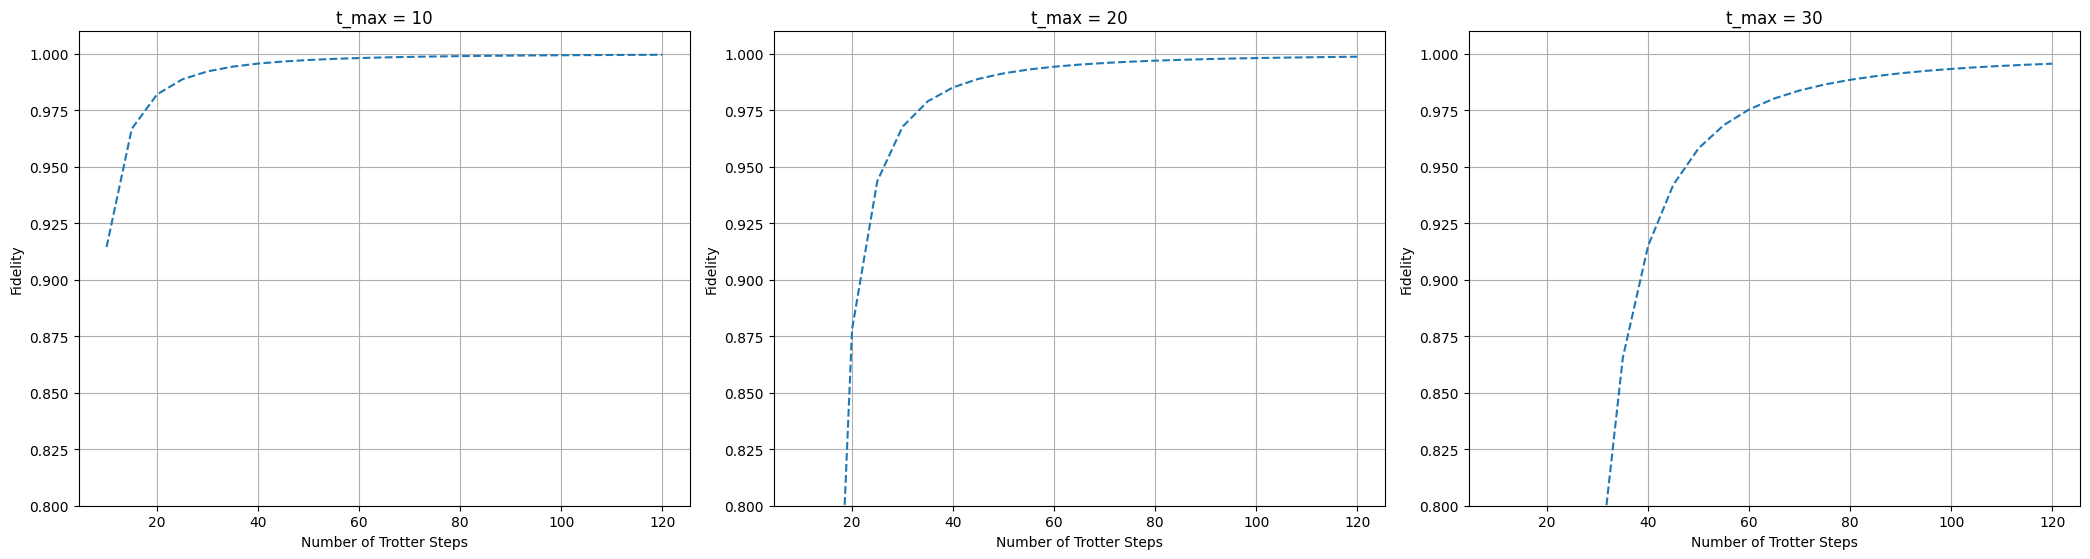

In [28]:
import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

t_max_values = [10, 20, 30]
v = 1.0
omega = 1.0
g = 0.5
num_qubits_per_qumode = 3
N_b = 2**num_qubits_per_qumode 

# Fermion initial state
fermion_init = [0, 1, 0, 0]

# Trotter step counts 
steps_list = np.arange(10, 121, 5)

fig, axs = plt.subplots(1, 3, figsize=(21, 6))
for idx, t_max in enumerate(t_max_values):
    # Final State
    exact_result = exact_qutip_holstein_sim(v=v, omega=omega, g=g, N_b=N_b,
                                             t_max=t_max, num_steps=101,
                                             fermion_init=fermion_init)
    psi_exact = exact_result.states[-1]

    fid_list = []  # fidelity for each number of steps
    for steps in steps_list:
        dt_trotter = t_max / steps  # time step 
        psi_trotter, _ = simulate_holstein_model(dt=dt_trotter, num_trotter=steps,
                                                  v=v, omega=omega, g=g,
                                                  fermion_init=fermion_init,
                                                  num_qubits_per_qumode=num_qubits_per_qumode)
        
        fid = qt.fidelity(psi_exact, psi_trotter)
        fid_list.append(fid)

    # Plot 
    ax = axs[idx]
    # ax.scatter(steps_list, fid_list, marker='o', color='blue', s=60)
    ax.plot(steps_list, fid_list, linestyle = '--')
    ax.set_xlabel("Number of Trotter Steps")
    ax.set_ylabel("Fidelity")
    ax.set_title(f"t_max = {t_max}")
    ax.grid(True)
    ax.set_ylim(0.8, 1.01)  # set common y-axis limits

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Compiling into Instruction Set Architecture
Thus far we have just treated all operators/gates equally. However, we need to consider compiling the hybrid oscillator-qubit gates into "native" or fundamental gates on the hardware.